In [120]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
carpeta = '/content/drive/My Drive/PrediccionCriptos'
archivos = os.listdir(carpeta)
print(archivos)

['ETH-500.parquet', 'PredecirCripto.ipynb', 'ETH-1000-5m.parquet', 'ETH-1000.parquet', 'ETH-1-Year-5min.parquet']


In [94]:
data_path = '/content/drive/My Drive/PrediccionCriptos/ETH-1-Year-5min.parquet'
eth_df = pd.read_parquet(data_path)
eth_df.shape

(105121, 6)

In [95]:
eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'])
eth_df.set_index('timestamp', inplace=True)

In [96]:
eth_df.head()

,open,high,low,close,volume
timestamp,,,,,
2023-05-11 03:35:00,1825.75,1828.76,1825.74,1827.73,1235.6817
2023-05-11 03:40:00,1827.73,1828.46,1827.31,1828.14,576.1996
2023-05-11 03:45:00,1828.15,1828.37,1826.51,1827.21,1135.1665
2023-05-11 03:50:00,1827.22,1827.54,1825.74,1826.34,741.7727
2023-05-11 03:55:00,1826.34,1827.61,1825.60,1827.61,651.9522


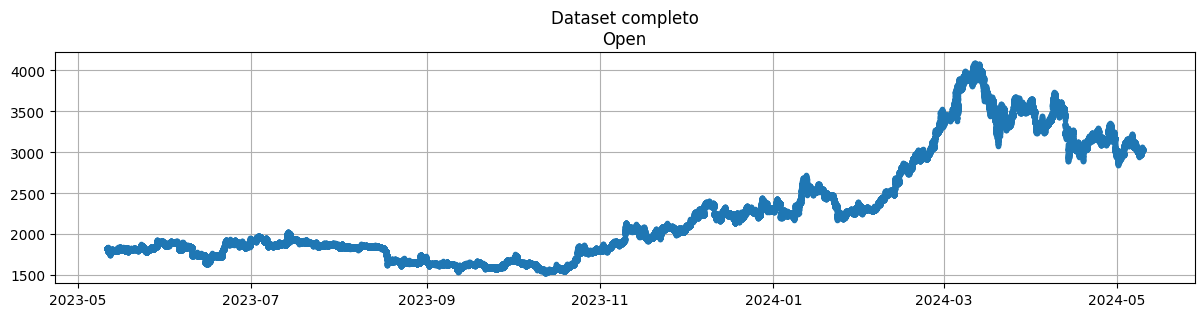

In [97]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset completo\nOpen")
ax1.plot(eth_df.high,marker='.',linewidth=0)
plt.grid(True)
plt.show()

In [98]:
eth_df.describe()

,open,high,low,close,volume
count,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000
mean,2262.597604,2264.738952,2260.340998,2262.609011,1214.105143
std,650.850029,652.198323,649.398173,650.852876,1749.056705
min,1524.220000,1526.760000,1521.000000,1524.220000,30.746300
25%,1804.640000,1805.880000,1803.350000,1804.630000,407.477400
50%,1958.220000,1959.960000,1956.600000,1958.250000,726.225700
75%,2547.050000,2549.430000,2544.140000,2547.050000,1338.252200
max,4091.810000,4093.920000,4085.720000,4091.810000,52372.648700


In [99]:
duplicates = eth_df[eth_df.duplicated()]
duplicates.count()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [105]:
train_ds = eth_df[:'2023'].iloc[:,1:2]
valid_ds = eth_df['2024':].iloc[:,1:2]

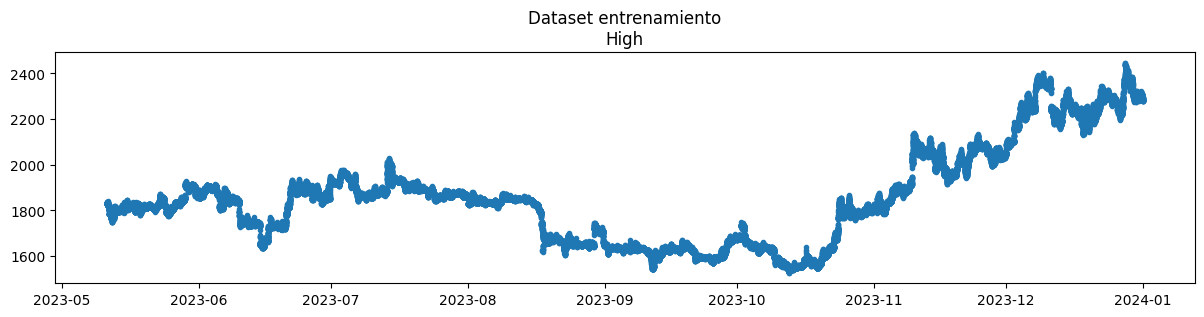

In [107]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset entrenamiento\nHigh")
ax1.plot( train_ds.high, marker = '.', linewidth = 0 )
plt.show()

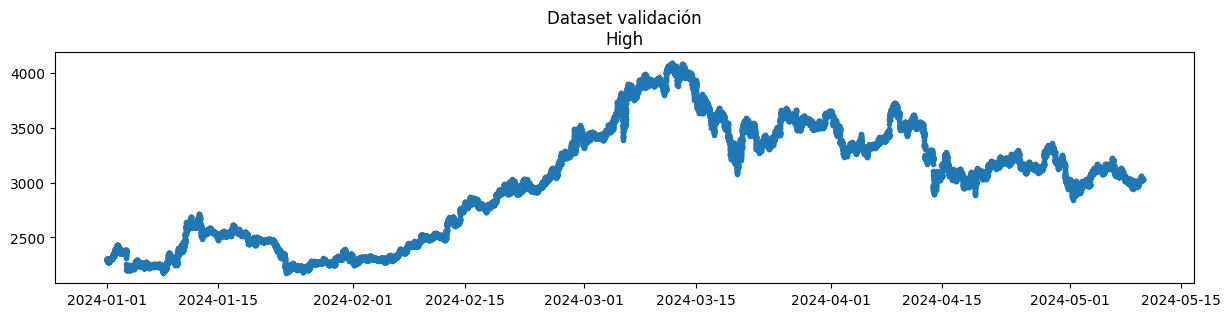

In [108]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset validación\nHigh")
ax1.plot( valid_ds.high, marker = '.', linewidth = 0 )
plt.show()

In [111]:
scaler = MinMaxScaler( feature_range = (0,1) )
train_ds_escalado = scaler.fit_transform(train_ds)

In [112]:
time_step = 100  # <-------- parametro: numero de valores a usar para predecir el siguiente
X_train = []
Y_train = []
m = len(train_ds_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(train_ds_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(train_ds_escalado[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

In [113]:
X_train.shape, Y_train.shape

((67537, 100), (67537,))

In [118]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [119]:
X_train.shape, Y_train.shape

((67537, 100, 1), (67537,))

In [121]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
num_neuron = 100

In [122]:
modelo = Sequential()
modelo.add( LSTM( units = num_neuron, input_shape = dim_entrada ) )
modelo.add( Dense( units = dim_salida ))

In [123]:
modelo.compile(optimizer='Adam', loss='mse')

In [125]:
%time modelo.fit( X_train, Y_train, epochs = 100, batch_size = 32, verbose = 1)

Epoch 1/100
2111/2111 [==============================] - 212s 101ms/step - loss: 7.7573e-05
Epoch 2/100
2111/2111 [==============================] - 163s 77ms/step - loss: 2.7701e-05
Epoch 3/100
2111/2111 [==============================] - 154s 73ms/step - loss: 2.2048e-05
Epoch 4/100
2111/2111 [==============================] - 157s 75ms/step - loss: 1.6185e-05
Epoch 5/100
2111/2111 [==============================] - 166s 79ms/step - loss: 1.2761e-05
Epoch 6/100
2111/2111 [==============================] - 164s 78ms/step - loss: 1.0227e-05
Epoch 7/100
2111/2111 [==============================] - 165s 78ms/step - loss: 8.8694e-06
Epoch 8/100
2111/2111 [==============================] - 161s 76ms/step - loss: 8.0588e-06
Epoch 9/100
2111/2111 [==============================] - 157s 75ms/step - loss: 7.8734e-06
Epoch 10/100
2111/2111 [==============================] - 155s 74ms/step - loss: 8.2839e-06
Epoch 11/100
2111/2111 [==============================] - 155s 73ms/step - loss: 7.4574e

In [127]:
x_test = valid_ds.values
x_test = scaler.transform(x_test)

In [128]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])

X_test = np.array( X_test )
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [129]:
X_test.shape, valid_ds.shape

((37384, 100, 1), (37484, 1))

In [130]:
prediccion = modelo.predict(X_test)
prediccion = scaler.inverse_transform(prediccion)

1169/1169 [==============================] - 33s 28ms/step


In [131]:
df_prediccion = pd.DataFrame(prediccion, index=valid_ds.index[time_step:], columns=['High'])

In [132]:
df_prediccion['High'][0]

2283.3225

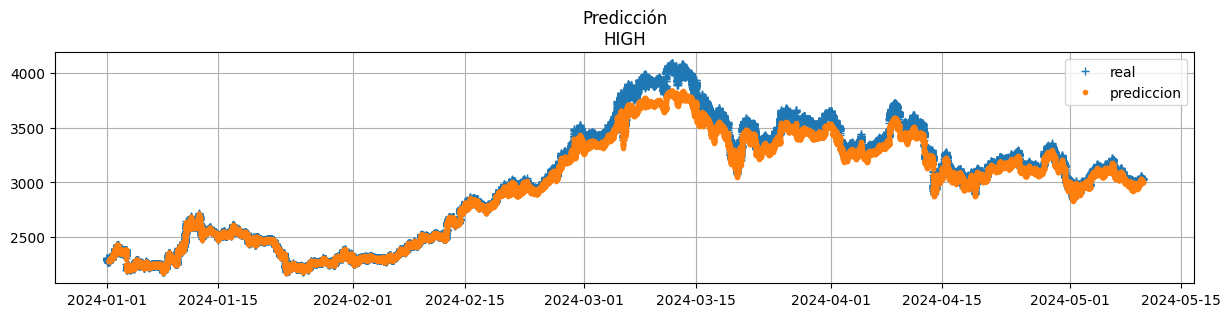

In [133]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción\nHIGH")
ax1.plot( valid_ds.high, marker = '+', linewidth = 0 )
ax1.plot( df_prediccion['High'], marker = '.', linewidth = 0 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [134]:
maximo = None
minimo_valor = None
for i in range(df_prediccion.shape[0]):
  diferencia = np.abs(valid_ds.high[i+time_step] - df_prediccion['High'][i])
  if( maximo == None ):
    maximo = diferencia
    minimo_valor = diferencia
  else:
    if diferencia  > maximo:
      maximo = diferencia
    else:
      if diferencia  < minimo_valor:
        minimo_valor = diferencia

print("La diferencia máxima es ",maximo)
print("La diferencia mínima es ",minimo_valor)

La diferencia máxima es  276.65204101562495
La diferencia mínima es  0.00033203124985448085


In [135]:
modelo.save("/content/drive/My Drive/PrediccionCriptos/modelo.h5")